In [21]:
%matplotlib inline

import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
import matplotlib.pyplot as plt
import re
import operator

In [3]:
titanic = pandas.read_csv("train.csv")
print(titanic.head(5))
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
       P

In [4]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

In [5]:
print(titanic["Sex"].unique())
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


In [6]:
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna('S')
titanic.loc[titanic["Embarked"] == 'S', "Embarked"] = 0
titanic.loc[titanic["Embarked"] == 'C', "Embarked"] = 1
titanic.loc[titanic["Embarked"] == 'Q', "Embarked"] = 2

['S' 'C' 'Q' nan]


In [7]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
alg = LinearRegression()
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)
predictions = []
for train, test in kf:
    train_predictors = (titanic[predictors].iloc[train,:])
    train_target = titanic["Survived"].iloc[train]
    alg.fit(train_predictors, train_target)
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)
predictions = np.concatenate(predictions, axis=0)

In [8]:
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(map(lambda x, y: x == y, predictions, titanic["Survived"]))/len(titanic["Survived"])
print(accuracy)

0.783389450056


In [9]:
alg = LogisticRegression(random_state=1)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.787878787879


In [10]:
titanic_test = pandas.read_csv("test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test.loc[titanic_test["Embarked"] == 'S', "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == 'C', "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == 'Q', "Embarked"] = 2
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].median())

In [11]:
alg = LogisticRegression(random_state=1)
alg.fit(titanic[predictors], titanic["Survived"])
predictions = alg.predict(titanic_test[predictors])
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kaggle.csv", index=False)

In [12]:
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.800224466891


In [13]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.819304152637


In [14]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

In [15]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, 
                 "Major": 7, "Col": 7, "Capt": 7,
                 "Mlle": 8, "Mme": 8, 
                 "Don": 9, 
                 "Lady": 10, "Countess": 10, "Jonkheer": 10, 
                 "Sir": 9, 
                 "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

print(pandas.value_counts(titles))

titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Lady          1
Sir           1
Jonkheer      1
Mme           1
Countess      1
Ms            1
Don           1
Capt          1
Name: Name, dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


In [16]:
family_id_mapping = {}

def get_family_id(row):
    last_name = row["Name"].split(",")[0]
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

family_ids = titanic.apply(get_family_id, axis=1)

family_ids[titanic["FamilySize"] < 3] = -1

print(pandas.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


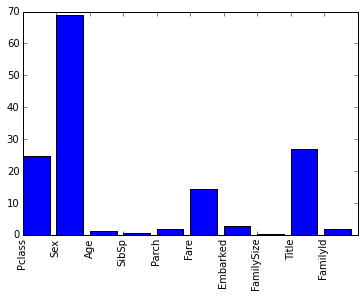

In [19]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

scores = -np.log10(selector.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [20]:
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
scores = cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.811447811448


In [22]:
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    for alg, predictors in algorithms:
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

predictions = np.concatenate(predictions, axis=0)

accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.819304152637


/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:23: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [23]:
titles = titanic_test["Name"].apply(get_title)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, 
                 "Major": 7, "Col": 7, "Capt": 7,
                 "Mlle": 8, "Mme": 8, 
                 "Don": 9, "Sir": 9,
                 "Lady": 10, "Countess": 10, "Jonkheer": 10, "Dona": 10,  
                 "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles

print(pandas.value_counts(titanic_test["Title"]))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64


In [28]:
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1

print(pandas.value_counts(family_ids))

titanic_test["FamilyId"] = family_ids

-1      384
 149      4
 25       3
 280      3
 27       2
 59       2
 633      2
 510      2
 167      2
 90       2
 162      1
 759      1
 449      1
 84       1
 269      1
 58       1
 43       1
 794      1
 918      1
 17       1
 14       1
 8        1
dtype: int64


In [29]:
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

In [31]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    alg.fit(titanic[predictors], titanic["Survived"])
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0
predictions = predictions.astype(int)

submission = pandas.DataFrame({"PassengerId": titanic_test["PassengerId"],
                               "Survived": predictions})
submission.to_csv("kaggle_gradientboosting.csv")